In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import layers

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
%matplotlib inline

from functools import partial

In [3]:
sess = tf.InteractiveSession()

In [4]:
def sample_gumbel(shape, eps=1e-20): 
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax(y / temperature)

In [19]:
NUM_SUITS = 2
NUM_NUMBERS = 5

HIDDEN_DIM = 128
VOCAB_SIZE = NUM_SUITS * NUM_NUMBERS
NUM_CLASSES = NUM_SUITS * NUM_NUMBERS

def build_graph(card_suit, card_number, targets, sample_type="gumbel-sf"):
    temperature = tf.constant(1.0)

    # Agent 1 reads card and makes an utterance.
    a1_hidden = layers.fully_connected(tf.concat(1, [card_suit, card_number]),
                                       HIDDEN_DIM)
    a1_logits = layers.fully_connected(a1_hidden,
                                       VOCAB_SIZE, activation_fn=None,
                                       biases_initializer=None)
    
    if sample_type == "gumbel-sf":
        a1_sample = gumbel_softmax_sample(a1_logits, temperature)
    elif sample_type == "sf":
        a1_sample = tf.nn.softmax(a1_logits / temperature)
    elif sample_type == "multinomial":
        a1_sample = tf.multinomial(a1_logits / temperature, 1)
        a1_sample = tf.squeeze(a1_sample, [1])
    else:
        raise ValueError("unknown sample_type %s" % sample_type)

    # Agent 2 reads utterance and makes a selection.
    a2_hidden = layers.fully_connected(a1_sample, HIDDEN_DIM)
    a2_logits = layers.fully_connected(a2_hidden, NUM_CLASSES, 
                                       activation_fn=None,
                                       biases_initializer=None)
    
    a2_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(a2_logits, targets)
    a2_loss = tf.reduce_mean(a2_loss)
    
    return temperature, a2_loss

In [20]:
def build_differentiable_model(learning_rate, sample_type="gumbel-sf"):
    card_suit = tf.placeholder(tf.float32, shape=(None, NUM_SUITS))
    card_number = tf.placeholder(tf.float32, shape=(None, NUM_NUMBERS))
    targets = tf.placeholder(tf.int32, shape=(None,))
    
    temperature, loss = build_graph(card_suit, card_number, targets,
                                    sample_type)
    
    opt = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_op = opt.minimize(loss)
    
    return (card_suit, card_number, targets, temperature), (train_op, loss)

In [21]:
def yield_batches(batch_size):
    n_cards = NUM_SUITS * NUM_NUMBERS
    assert batch_size <= n_cards
    while True:
        cards = np.random.choice(n_cards, size=batch_size, replace=False)
        
        suits = np.floor_divide(cards, NUM_NUMBERS)
        numbers = np.mod(cards, NUM_NUMBERS)
        
        input_suits = np.zeros((batch_size, NUM_SUITS))
        input_numbers = np.zeros((batch_size, NUM_NUMBERS))
        
        batch_range = np.arange(batch_size)
        input_suits[batch_range, suits] = 1
        input_numbers[batch_range, numbers] = 1
        
        yield input_suits, input_numbers, cards

In [22]:
def test_model(build_fn, batch_size, n_iterations, learning_rate):
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    inputs, outputs = build_fn(learning_rate)
    sess.run(tf.global_variables_initializer())
    
    card_suit, card_number, targets, temperature = inputs
    train_op, loss = outputs
    
    losses = []
    for t, batch_data in zip(range(n_iterations),
                             yield_batches(batch_size)):
        b_suits, b_numbers, b_targets = batch_data

        b_temperature = 2.0 * np.exp(-1e-4 * t)
        feed = {card_suit: b_suits, card_number: b_numbers,
                targets: b_targets, temperature: b_temperature}
        _, b_loss = sess.run([train_op, loss], feed)

        losses.append(b_loss)
        
    return losses

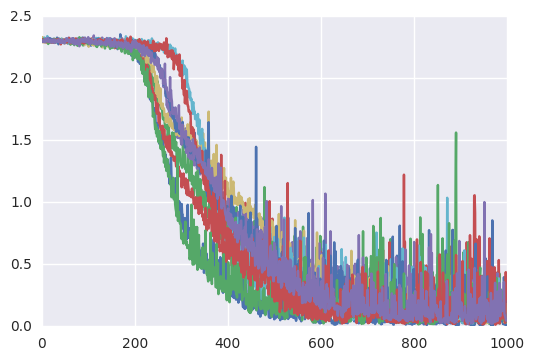

In [47]:
build_gumbel_model = partial(build_differentiable_model, sample_type="gumbel-sf")

all_gsf_losses = []
for _ in range(10):
    lr = np.random.uniform(low=0.04, high=0.06)
    all_gsf_losses.append(test_model(build_gumbel_model, 10, 1000, lr))
    
for losses in all_gsf_losses:
    plt.plot(losses)

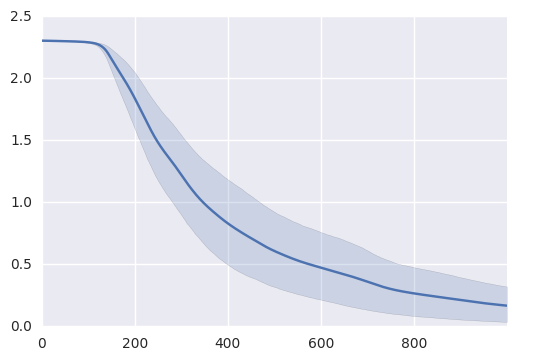

In [48]:
sns.tsplot(all_losses, ci=95)

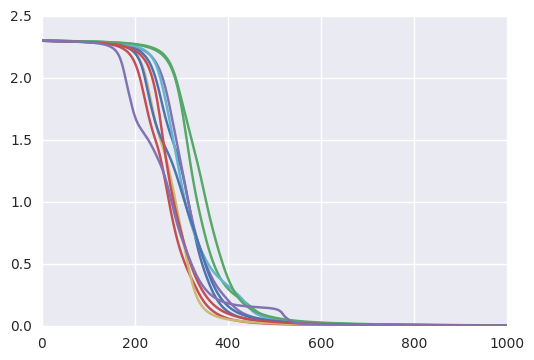

In [49]:
build_softmax_model = partial(build_differentiable_model, sample_type="sf")

all_sf_losses = []
for _ in range(10):
    lr = np.random.uniform(low=0.04, high=0.06)
    all_sf_losses.append(test_model(build_softmax_model, 10, 1000, lr))
    
for losses in all_sf_losses:
    plt.plot(losses)

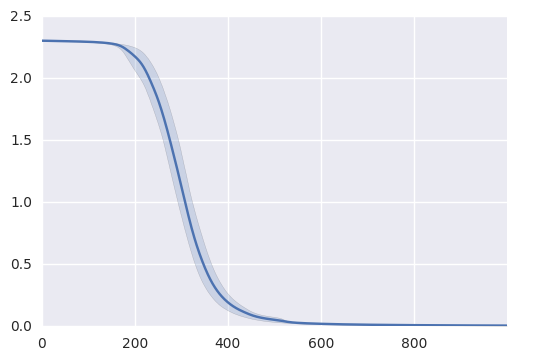

In [50]:
sns.tsplot(all_sf_losses, ci=95)